## PyTorch Tutorial
MILA, November 2017

By Sandeep Subramanian

## Classifying MNIST & CIFAR-10 with Convnets & ResNets

In [25]:
import time
import numpy as np
from __future__ import print_function

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F

In [27]:
import torchvision
import torchvision.transforms

In [28]:
import matplotlib.pyplot as plt

### Define image transformations &  Initialize datasets

In [29]:
mnist_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, transform=mnist_transforms, download=True)
mnist_test = torchvision.datasets.MNIST(root='./data', train=False, transform=mnist_transforms, download=True)

### Create multi-threaded DataLoaders

In [30]:
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=1000, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=1000, shuffle=True, num_workers=2)

In [31]:
train_loader

### Main classifier that subclasses nn.Module

In [32]:
class Classifier(nn.Module):
    """Convnet Classifier"""
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv = nn.Sequential(
            # Layer 1
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=1),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 2
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 3
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 4
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        )
        # Logistic Regression
        self.clf = nn.Linear(128, 10)

    def forward(self, x):
        return self.clf(self.conv(x).squeeze())


In [33]:
cuda_available = torch.cuda.is_available()
print(cuda_available)

True


In [34]:
clf = Classifier()
if cuda_available:
    clf = clf.cuda()
optimizer = torch.optim.Adam(clf.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
# This criterion combines nn.LogSoftmax() and nn.NLLLoss() in one single class.

In [36]:
#torch.optim.SGD.

In [37]:
num_epochs = 10
ep, train_error, valid_error = [], [], []
for epoch in range(num_epochs):
    losses = []
    ep.append(epoch)
  
    # Train
    total_train = 0
    correct_train = 0
    
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        if cuda_available:
            inputs, targets = inputs.cuda(), targets.cuda()

        optimizer.zero_grad()
        outputs = clf(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        losses.append(loss.data.item())

        outputs = clf(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total_train += targets.size(0)
        correct_train += predicted.eq(targets.data).cpu().sum()
        
        '''if batch_idx%num_epochs==0:
            print('Epoch : %d Loss : %.3f ' % (epoch, np.mean(losses)))'''
            
    train_error.append(100-100.*correct_train/total_train)
    
    '''total_train = total_train
    correct_train = correct_train'''
    
    # Evaluate
    clf.eval()
    
    total_valid = 0
    correct_valid = 0
    
    for batch_idx, (inputs, targets) in enumerate(test_loader):
        if cuda_available:
            inputs, targets = inputs.cuda(), targets.cuda()

        outputs = clf(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total_valid += targets.size(0)
        correct_valid += predicted.eq(targets.data).cpu().sum()

    valid_error.append(100-100.*correct_valid/total_valid)
    
    print('Epoch: %d, Train Acc.: %.3f, Test Acc.: %.3f' % (epoch, 100.*correct_train/total_train, 100.*correct_valid/total_valid))
    print('---------------------------------------------------')
    
    clf.train()

Epoch: 0, Train Acc.: 18.000, Test Acc.: 27.000
---------------------------------------------------
Epoch: 1, Train Acc.: 42.000, Test Acc.: 67.000
---------------------------------------------------
Epoch: 2, Train Acc.: 64.000, Test Acc.: 80.000
---------------------------------------------------
Epoch: 3, Train Acc.: 74.000, Test Acc.: 86.000
---------------------------------------------------
Epoch: 4, Train Acc.: 80.000, Test Acc.: 89.000
---------------------------------------------------
Epoch: 5, Train Acc.: 83.000, Test Acc.: 90.000
---------------------------------------------------
Epoch: 6, Train Acc.: 86.000, Test Acc.: 91.000
---------------------------------------------------
Epoch: 7, Train Acc.: 87.000, Test Acc.: 92.000
---------------------------------------------------
Epoch: 8, Train Acc.: 88.000, Test Acc.: 93.000
---------------------------------------------------
Epoch: 9, Train Acc.: 89.000, Test Acc.: 93.000
---------------------------------------------------


In [38]:
print(clf.eval())

Classifier(
  (conv): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Dropout(p=0.5)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): Dropout(p=0.5)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): Dropout(p=0.5)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): Dropout(p=0.5)
    (14): ReLU()
    (15): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (clf): Linear(in_features=128, out_features=10, bias=True)
)


#### Plotting the training and validation errors

([<matplotlib.axis.XTick at 0x1a2069c0160>,
 <a list of 9 Text xticklabel objects>)

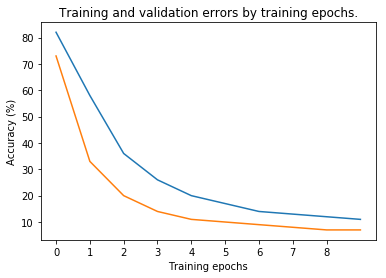

In [39]:
plt.plot(ep, train_error)
plt.plot(ep, valid_error)
plt.ylabel("Accuracy (%)")
plt.xlabel("Training epochs")
plt.title('Training and validation errors by training epochs.')
#ax.set_xticklabels([''] + v)
plt.xticks(np.arange(min(ep), max(ep), 1))
#plt.yticks(np.arange(min(v)*100, max(v)*100, 0.05))

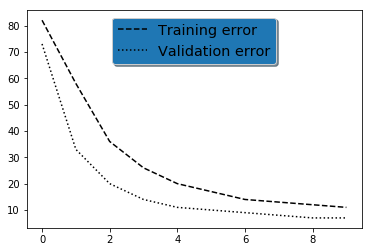

In [40]:
# Create plots with pre-defined labels.
fig, ax = plt.subplots()
ax.plot(ep, train_error, 'k--', label='Training error')
ax.plot(ep, valid_error, 'k:', label='Validation error')
#ax.plot(a, c + d, 'k', label='Total message length')

'''ax.get_xlabel()
ax.get_ylabel("Accuracy (%)")
#ax.get_xlabel("Training epochs")
ax.title('Training and validation errors by training epochs.')
#ax.set_xticklabels([''] + v)
ax.xticks(np.arange(min(ep), max(ep), 1))'''

legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C0')

plt.show()

### CIFAR10

In [54]:
cifar_train_transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomCrop(32, padding=4),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


cifar_test_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=cifar_train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=cifar_test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)



Files already downloaded and verified
Files already downloaded and verified


### Create a single Residual Block

Adapted from https://github.com/kuangliu/pytorch-cifar and https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py

In [55]:
class ResidualBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        
        # Conv Layer 1
        self.conv1 = nn.Conv2d(
            in_channels=in_channels, out_channels=out_channels,
            kernel_size=(3, 3), stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        # Conv Layer 2
        self.conv2 = nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels,
            kernel_size=(3, 3), stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)
    
        # Shortcut connection to downsample residual
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_channels=in_channels, out_channels=out_channels,
                    kernel_size=(1, 1), stride=stride, bias=False
                ),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [56]:
class CIFARResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(CIFARResNet18, self).__init__()
        
        # Initial input conv
        self.conv1 = nn.Conv2d(
            in_channels=3, out_channels=64, kernel_size=(3, 3),
            stride=1, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(64)
        
        # Create stages 1-4
        self.stage1 = self._create_stage(64, 64, stride=1)
        self.stage2 = self._create_stage(64, 128, stride=2)
        self.stage3 = self._create_stage(128, 256, stride=2)
        self.stage4 = self._create_stage(256, 512, stride=2)
        self.linear = nn.Linear(512, num_classes)
    
    # A stage is just two residual blocks for ResNet18
    def _create_stage(self, in_channels, out_channels, stride):
        return nn.Sequential(
            ResidualBlock(in_channels, out_channels, stride),
            ResidualBlock(out_channels, out_channels, 1)
        )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.stage1(out)
        out = self.stage2(out)
        out = self.stage3(out)
        out = self.stage4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [57]:
clf = CIFARResNet18()
if cuda_available:
    clf = clf.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(clf.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[150, 200], gamma=0.1)

In [58]:
for epoch in range(200):
    losses = []
    scheduler.step()
    # Train
    start = time.time()
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        if cuda_available:
            inputs, targets = inputs.cuda(), targets.cuda()

        optimizer.zero_grad()
        outputs = clf(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        losses.append(loss.data[0])
        print('Epoch : %d Loss : %.3f ' % (epoch, np.mean(losses)))
    end = time.time()

    print('Epoch : %d Loss : %.3f Time : %.3f seconds ' % (epoch, np.mean(losses), end - start))
    # Evaluate
    clf.eval()
    total = 0
    correct = 0
    for batch_idx, (inputs, targets) in enumerate(testloader):
        if cuda_available:
            inputs, targets = inputs.cuda(), targets.cuda()

        outputs = clf(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()

    print('Epoch : %d Test Acc : %.3f' % (epoch, 100.*correct/total))
    print('--------------------------------------------------------------')
    clf.train()

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:15: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  from ipykernel import kernelapp as app


Epoch : 0 Loss : 2.358 
Epoch : 0 Loss : 2.361 


Process Process-22:
Process Process-21:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/anaconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/anaconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
    self.run()
  File "/anaconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/anaconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
    self._target(*self._args, **self._kwargs)
  File "/anaconda2/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
  File "/anaconda2/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
    r = index_queue.get()
  File "/anaconda2/lib/python2.7/multiprocessing/queues.py", line 376, in get
  File "/anaconda2/lib/python2.7/multiprocessing/queues.py", line 376, in get
    return recv()
  

KeyboardInterrupt: 